In [19]:
# This cell sets up the necessary libraries and loads the dataset. The warnings.filterwarnings('ignore') line is used to suppress
# any warnings that might clutter the output.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import time

warnings.filterwarnings('ignore')

file_path = "C:\\Users\\karan\\Downloads\\Fraud.csv"
df = pd.read_csv(file_path)

print(f"Original dataset size: {df.shape[0]}\n")

Original dataset size: 6362620



In [20]:
# This cell performs data cleaning and preprocessing. It removes unnecessary columns, creates dummy variables for categorical features, 
# and generates new features to enhance the model’s predictive power.
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df['balanceOrg_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceDest_change'] = df['newbalanceDest'] - df['oldbalanceDest']
df['is_large_transaction'] = df['amount'].apply(lambda x: 1 if x > 200000 else 0)
df['orig_balance_zero'] = df['oldbalanceOrg'].apply(lambda x: 1 if x == 0 else 0)
df['dest_balance_zero'] = df['oldbalanceDest'].apply(lambda x: 1 if x == 0 else 0)

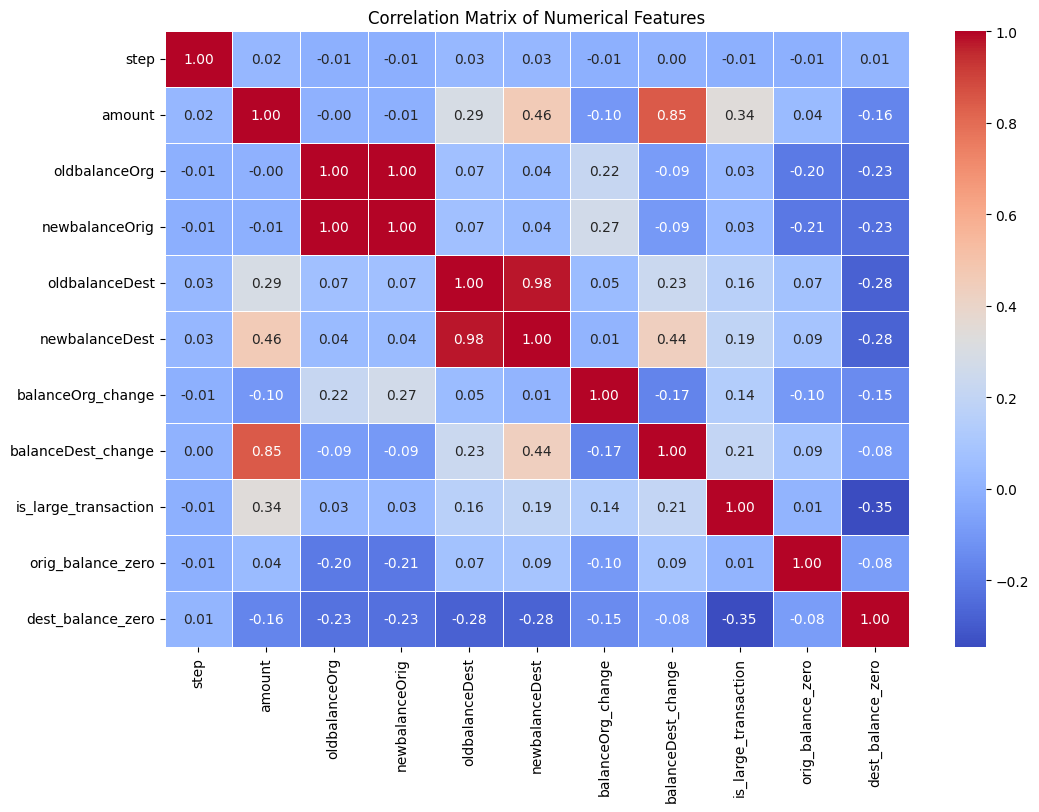

No features with high multicollinearity detected (VIF > 5).



In [21]:
# This cell calculates and visualizes the correlation matrix of numerical features. It also calculates the Variance Inflation Factor (VIF)
# to identify multicollinearity among features, allowing you to decide whether to drop highly collinear features.
numerical_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
                     'balanceOrg_change', 'balanceDest_change', 'is_large_transaction', 'orig_balance_zero', 'dest_balance_zero']
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

X_vif = df[['step', 'amount', 'balanceOrg_change', 'balanceDest_change', 'orig_balance_zero', 'dest_balance_zero',
            'is_large_transaction', 'type_CASH_OUT', 'type_DEBIT', 'type_TRANSFER']]

scaler_vif = StandardScaler()
X_vif_scaled = pd.DataFrame(scaler_vif.fit_transform(X_vif), columns=X_vif.columns)

vif_df = calculate_vif(X_vif_scaled)

high_vif_features = vif_df[vif_df["VIF"] > 5]
if not high_vif_features.empty:
    print("Warning: The following features have high multicollinearity (VIF > 5):")
    print(high_vif_features)
    user_input = input("Do you want to remove these features to reduce multicollinearity? (yes/no): ").strip().lower()

    if user_input == 'yes':
        features_to_drop = high_vif_features["Feature"].tolist()
        df.drop(columns=features_to_drop, inplace=True)
        print(f"Features dropped: {features_to_drop}\n")
    else:
        print("No features removed.\n")
else:
    print("No features with high multicollinearity detected (VIF > 5).\n")

In [22]:
# This cell splits the dataset into training, validation, and test sets. It also scales the features to ensure that they have similar ranges, which 
# is important for many machine learning algorithms.
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val)

print(f"Training+Validation set size: {X_train_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training+Validation set size: 4453834
Test set size: 1908786
Training set size: 3117683
Validation set size: 1336151



In [23]:
# This cell builds and trains a LightGBM model using cross-validation. It calculates the scale of positive weights to handle class imbalance 
# and evaluates the model using AUC scores and training times.
num_pos = sum(y_train)
num_neg = len(y_train) - num_pos
scale_pos_weight = num_neg / num_pos

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'is_unbalance': False,
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

lgb_clf = lgb.LGBMClassifier(**lgb_params, n_estimators=500)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
fold_training_times = []

print("Training and Evaluating Model with Cross-Validation...\n")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train), 1):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    start_time = time.time()
    lgb_clf.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
    )
    end_time = time.time()
    
    fold_training_time = end_time - start_time
    fold_training_times.append(fold_training_time)
    
    y_val_proba = lgb_clf.predict_proba(X_val_fold)[:, 1]
    auc_score = roc_auc_score(y_val_fold, y_val_proba)
    auc_scores.append(auc_score)
    
    print(f"Fold {fold} Training Time: {fold_training_time:.2f} seconds")
    print(f"Fold {fold} AUC Score: {auc_score:.4f}\n")

average_auc_score = sum(auc_scores) / len(auc_scores)
average_training_time = sum(fold_training_times) / len(fold_training_times)

print(f"Average AUC Score across all folds: {average_auc_score:.4f}")
print(f"Average Fold Training Time: {average_training_time:.2f} seconds\n")

Training and Evaluating Model with Cross-Validation...

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.991877
Fold 1 Training Time: 11.28 seconds
Fold 1 AUC Score: 0.9919

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.989541
Fold 2 Training Time: 9.95 seconds
Fold 2 AUC Score: 0.9895

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.989305
Fold 3 Training Time: 10.31 seconds
Fold 3 AUC Score: 0.9893

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.992181
Fold 4 Training Time: 10.02 seconds
Fold 4 AUC Score: 0.9922

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.989276
Fold 5 Training Time: 10.51 seconds
Fold 5 AUC Score: 0.9893

Average AUC Sco

In [24]:
# This cell evaluates the final model on the test set, providing metrics such as classification report, ROC-AUC score, and confusion matrix.
# It also demonstrates the effect of adjusting the decision threshold.

start_time = time.time()  # Start time for testing
y_test_proba = lgb_clf.predict_proba(X_test_scaled)[:, 1]
y_test_pred = lgb_clf.predict(X_test_scaled)
end_time = time.time()  # End time for testing

test_processing_time = end_time - start_time
average_time_per_transaction = test_processing_time / X_test_scaled.shape[0]

print(f"Average time to process each transaction: {average_time_per_transaction:.8f} seconds\n")

print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC-AUC Score: {roc_auc_score(y_test, y_test_proba):.4f}\n")

cm = confusion_matrix(y_test, y_test_pred)
print(f"Confusion Matrix:\n{cm}\n")

threshold = 0.2  # Example threshold; adjust based on precision-recall tradeoff
y_test_pred_adjusted = (y_test_proba >= threshold).astype(int)

print("Adjusted Test Classification Report:\n", classification_report(y_test, y_test_pred_adjusted))

Average time to process each transaction: 0.00000367 seconds

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906322
           1       0.05      0.99      0.10      2464

    accuracy                           0.98   1908786
   macro avg       0.52      0.98      0.54   1908786
weighted avg       1.00      0.98      0.99   1908786

Test ROC-AUC Score: 0.9911

Confusion Matrix:
[[1860030   46292]
 [     30    2434]]

Adjusted Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906322
           1       0.05      0.99      0.10      2464

    accuracy                           0.98   1908786
   macro avg       0.52      0.98      0.54   1908786
weighted avg       1.00      0.98      0.99   1908786



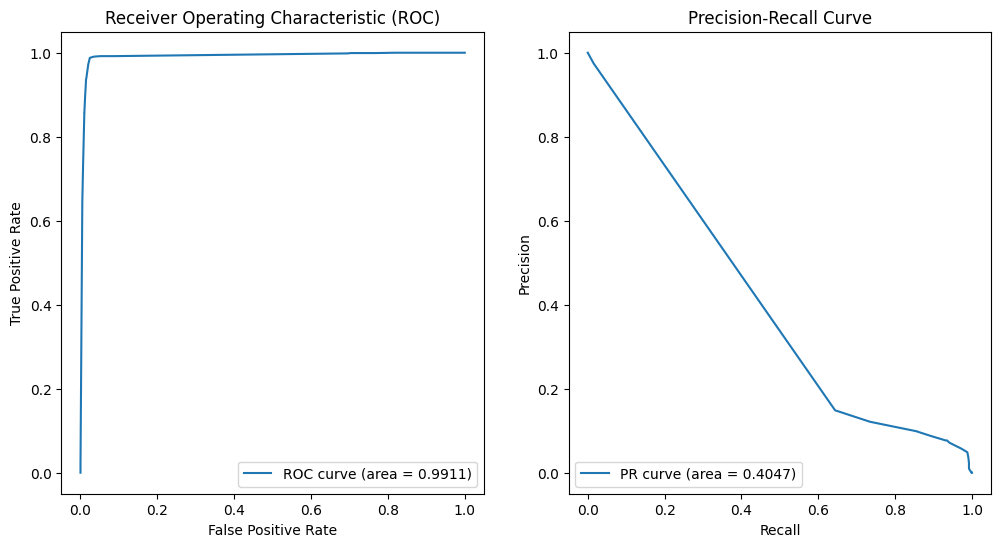

In [25]:
#This cell visualizes the ROC and Precision-Recall curves to assess the model’s performance across different thresholds.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_test_proba):.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {auc(recall, precision):.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [26]:
# This cell provides insights into feature importance, summarizes key factors for fraudulent transactions, and offers recommendations for 
# fraud prevention. It addresses key factors, makes sense of them, and suggests actions for enhancing fraud detection.
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features for Fraud Detection:")
print(importance_df.head(10))

print("Summary of Key Factors in Fraudulent Transactions:")
print(df[df['isFraud'] == 1][['amount', 'balanceOrg_change', 'balanceDest_change', 'is_large_transaction', 'orig_balance_zero', 'dest_balance_zero']].describe())

print("Fraud Prevention Recommendations:\n")
print(f"Monitor Large Transactions: Implement monitoring systems to flag transactions over {df['amount'].quantile(0.95):.2f}.")
print(f"Zero Balance Anomalies: Flag transactions with zero balances for further review. Total zero balance transactions: {df['orig_balance_zero'].sum() + df['dest_balance_zero'].sum()}, Fraudulent zero balance transactions: {df[(df['isFraud'] == 1) & ((df['orig_balance_zero'] == 1) | (df['dest_balance_zero'] == 1))].shape[0]}.")
print("Anomaly Detection: Regularly update thresholds for anomaly detection based on evolving fraud patterns.")
print("Automated Alerts: Set up automated alerts for high-risk transactions.")
print("Approval Processes: Introduce additional approval steps for flagged transactions.")
print("Real-time Monitoring: Enhance systems to monitor transactions in real-time.")
print("Model Retraining: Schedule regular intervals for retraining the fraud detection model.")
print("Performance Evaluation: Continuously assess and update the model based on new fraud trends.")

Top 10 Important Features for Fraud Detection:
               Feature  Importance
1               amount          11
2        oldbalanceOrg           6
3       newbalanceOrig           5
10   balanceOrg_change           4
6        type_CASH_OUT           2
0                 step           1
11  balanceDest_change           1
4       oldbalanceDest           0
5       newbalanceDest           0
7           type_DEBIT           0
Summary of Key Factors in Fraudulent Transactions:
             amount  balanceOrg_change  balanceDest_change  \
count  8.213000e+03       8.213000e+03        8.213000e+03   
mean   1.467967e+06      -1.457275e+06        7.354580e+05   
std    2.404253e+06       2.396099e+06        1.856984e+06   
min    0.000000e+00      -1.000000e+07       -3.152261e+05   
25%    1.270913e+05      -1.503035e+06        0.000000e+00   
50%    4.414234e+05      -4.363175e+05        0.000000e+00   
75%    1.517771e+06      -1.245826e+05        4.452574e+05   
max    1.000000e+07  